In [1]:
import tensorflow as tf
import numpy as np

In [73]:
from tensorflow import keras

In [44]:
from rotation_utils import *

In [74]:
class CosLayer(layers.Layer):
    def __init__(self):
        super(CosLayer, self).__init__()
        
        
    # 변수를 만듭니다.
    def build(self, input_shape):
        pass

    # call 메서드가 그래프 모드에서 사용되면
    # training 변수는 텐서가 됩니다.
    @tf.function
    def call(self, input):
        return tf.cos(input)
    
class SinLayer(layers.Layer):
    def __init__(self):
        super(SinLayer, self).__init__()
        
        
    # 변수를 만듭니다.
    def build(self, input_shape):
        pass

    # call 메서드가 그래프 모드에서 사용되면
    # training 변수는 텐서가 됩니다.
    @tf.function
    def call(self, input):
        return tf.sin(input)

In [75]:
class Trigonometric:
    def __init__(self, q):
        self.q = q
        self.cos = CosLayer()(q)
        self.sin = SinLayer()(q)

In [128]:
class RotMatLayer(layers.Layer):
    def __init__(self, axis):
        self.axis = axis
        super(RotMatLayer, self).__init__()
        if self.axis==1:
            self.r1 = tf.constant([[1,0,0],
                                   [0,0,0],
                                   [0,0,0]], dtype='float32')
            self.rc = tf.constant([[0,0,0],
                                   [0,1,0],
                                   [0,0,1]], dtype='float32')
            self.rs = tf.constant([[0,0,0],
                                   [0,0,-1],
                                   [0,1,0]], dtype='float32')
        elif self.axis==2:
            self.r1 = tf.constant([[0,0,0],
                                   [0,1,0],
                                   [0,0,0]], dtype='float32')
            self.rc = tf.constant([[1,0,0],
                                   [0,0,0],
                                   [0,0,1]], dtype='float32')
            self.rs = tf.constant([[0,0,1],
                                   [0,0,0],
                                   [-1,0,0]], dtype='float32')
        elif self.axis==3:
            self.r1 = tf.constant([[0,0,0],
                                   [0,0,0],
                                   [0,0,1]], dtype='float32')
            self.rc = tf.constant([[1,0,0],
                                   [0,1,0],
                                   [0,0,0]], dtype='float32')
            self.rs = tf.constant([[0,-1,0],
                                   [1,0,0],
                                   [0,0,0]], dtype='float32')
        else:
            raise(RuntimeError("axis should be in [1,2,3]"))
        
    # 변수를 만듭니다.
    def build(self, input_shape):
        pass

    # call 메서드가 그래프 모드에서 사용되면
    # training 변수는 텐서가 됩니다.
    @tf.function
    def call(self, input):
        return self.r1 + self.rc*tf.cos(input) + self.rs*tf.sin(input)
    


In [164]:
class RotZYXLayer(layers.Layer):
    def __init__(self):
        super(RotZYXLayer, self).__init__()
        self.Rz = RotMatLayer(3)
        self.Ry = RotMatLayer(2)
        self.Rx = RotMatLayer(1)
        
    # 변수를 만듭니다.
    def build(self, input_shape):
        pass

    # call 메서드가 그래프 모드에서 사용되면
    # training 변수는 텐서가 됩니다.
    @tf.function
    def call(self, inputs):
        Rz = self.Rz(inputs[0])
        Ry = self.Ry(inputs[1])
        Rx = self.Rx(inputs[2])
        return tf.matmul(tf.matmul(Rz,Ry),Rx)

In [168]:
from enum import Enum
class LinkType(Enum):
    FIXED = 0
    REVOLUTE = 1
    LINEAR = 2

In [177]:
class LinkLayer(layers.Layer):
    def __init__(self, Roff, Poff, axis, ltype, lname):
        super(LinkLayer, self).__init__()
        self.Roff = tf.constant(Roff)
        self.Poff = tf.constant(Poff)
        self.axis = axis
        self.ltype = ltype
        self.lname = lname
        if self.ltype == LinkType.REVOLUTE:
            self.Rjnt = RotMatLayer(axis=self.axis)
            self.Pjnt = tf.constant(np.zeros((3,1),dtype='float32'))
        elif self.ltype == LinkType.REVOLUTE:
            self.Rjnt = tf.constant(np.identity(3,dtype='float32'))
            __pjnt = np.zeros((3,1))
            __pjnt[axis] = 1
            self.Pjnt = tf.constant(__pjnt)
        elif self.ltype == LinkType.FIXED:
            self.Rjnt = tf.constant(np.identity(3,dtype='float32'))
            self.Pjnt = tf.constant(np.zeros((3,1),dtype='float32'))
            
        
    # 변수를 만듭니다.
    def build(self, input_shape):
        pass

    # call 메서드가 그래프 모드에서 사용되면
    # training 변수는 텐서가 됩니다.
    @tf.function
    def call(self, inputs):
        Rpre = inputs[0]
        Ppre = inputs[1]
        q = inputs[2]
        if self.ltype == LinkType.REVOLUTE:
            Rjnt = self.Rjnt(q)
            Pjnt = self.Pjnt
        elif self.ltype == LinkType.REVOLUTE:
            Rjnt = self.Rjnt
            Pjnt = self.Pjnt*q
        elif self.ltype == LinkType.FIXED:
            Rjnt = self.Rjnt
            Pjnt = self.Pjnt
        Rpo = tf.matmul(Rpre,self.Roff)
        Ppo = tf.matmul(Rpre,self.Poff)+Ppre
        Rcur = tf.matmul(Rpo,Rjnt)
        Pcur = tf.matmul(Rpo,Pjnt)+Ppo
        return Rcur, Pcur

In [250]:
link0 = LinkLayer(Roff=np.identity(3,dtype='float32'), 
          Poff=np.array((0,0.3,0),dtype='float32').reshape((3,1)), 
          axis=3, ltype=LinkType.REVOLUTE, lname='l0')
link1 = LinkLayer(Roff=np.identity(3,dtype='float32'), 
          Poff=np.array((0,0.3,0),dtype='float32').reshape((3,1)), 
          axis=3, ltype=LinkType.REVOLUTE, lname='l1')
link2 = LinkLayer(Roff=np.identity(3,dtype='float32'), 
          Poff=np.array((0,0.3,0),dtype='float32').reshape((3,1)), 
          axis=3, ltype=LinkType.FIXED, lname='l2')

In [260]:
qvec = []
Pvec_list = []
for _ in range(10):
    q = (np.random.rand(2)*2-1)*np.pi/3
    qvec += [q]
    l0 = link0((np.identity(3,dtype=np.float32), 
                np.zeros((3,1),dtype=np.float32), 
                q[0]))
    l1 = link1((l0+(q[1],)))
    l2 = link2((l1+(0,)))
    Pvec = np.array([l0[1], l1[1], l2[1]]).reshape(-1,3)
    Pvec_list += [Pvec]
Pvec_list=np.array(Pvec_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.5109295681118965,
 0.4615947142243385,
 0.27151375114917753,
 0.8982114881277085)

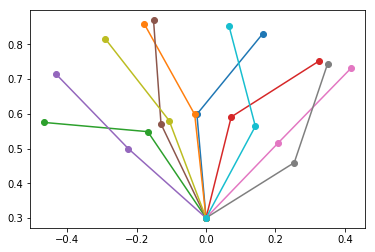

In [261]:
for Pvec in Pvec_list:
    plt.plot(Pvec[:,0],Pvec[:,1],'-o')
plt.axis('equal')

In [195]:
l1

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0. ],
        [0.6],
        [0. ]], dtype=float32)>)

In [165]:
dif_vec = []
for _ in range(10):
    q = np.random.rand(3).astype('float32')*2*np.pi-np.pi
    dif=RotZYXLayer()(q)-Rot_zyx(*q)
    dif_vec += [tf.norm(dif)]

In [155]:
axis_vec = []
q_vec = []
dif_vec = []
for _ in range(100):
    axis = np.random.choice(3)+1
    q = np.random.rand()*2*np.pi-np.pi
    dif=RotMatLayer(axis)(np.deg2rad(q,dtype='float32'))-Rot_axis(axis,np.deg2rad(q,dtype='float32'))
    axis_vec += [axis]
    q_vec += [q]
    dif_vec += [tf.norm(dif)]

In [27]:
def Rot_axis_tf(axis, q_tri):
    if not isinstance(q_tri, Trigonometric):
        q_tri = Trigonometric(q_tri)
    if axis==1:
        r1 = tf.constant([[1,0,0],[0,0,0],[0,0,0]])
        rc = tf.constant([[0,0,0],[0,1,0],[0,0,1]])
        rs = tf.constant([[0,0,0],[0,0,-1],[0,1,0]])
        R = tf.Variable([[1,0,0],
                         [0,q_tri.cos,-q_tri.sin],
                         [0,q_tri.sin,q_tri.cos]])
    if axis==2:
        R = tf.Variable([[q_tri.cos,0,q_tri.sin],
                         [0,1,0],
                         [-q_tri.sin,0,q_tri.cos]])
    if axis==3:
        R = tf.Variable([[q_tri.cos,-q_tri.sin,0],
                         [q_tri.sin,q_tri.cos,0],
                         [0,0,1]])
    return R

def Rot_zyx_tf(zr,yr,xr):
    '''
    zyx rotatio matrix - caution: axis order: z,y,x
    '''
    R = tf.matmul(tf.matmul(Rot_axis_tf(3,zr),Rot_axis_tf(2,yr)),Rot_axis_tf(1,xr))
    return R

In [28]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [35]:
RotMatLayer(1)

In [30]:
x = Rot_axis_tf(1, tf.Variable(np.deg2rad(90)))
y = Rot_axis_tf(1, tf.Variable(np.deg2rad(0)))

In [31]:
x

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float64, numpy=
array([[ 1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  6.123234e-17, -1.000000e+00],
       [ 0.000000e+00,  1.000000e+00,  6.123234e-17]])>

In [14]:
Rot_zyx_tf(*np.deg2rad([90,0,0]))

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]])>

In [24]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()

    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [26]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16117172128810620802, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12140321621432362811
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2898324905375479082
 physical_device_desc: "device: XLA_GPU device"]

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.1
training_steps = 2000
batch_size = 50
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:

# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # First fully-connected hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

In [6]:

# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [7]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
import time

In [9]:
time_vec = []
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    t1 = time.time()
    run_optimization(batch_x, batch_y)
    t2 = time.time()
    time_vec += [t2-t1]
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.279948, accuracy: 0.920000
step: 200, loss: 0.265860, accuracy: 0.940000
step: 300, loss: 0.312644, accuracy: 0.880000
step: 400, loss: 0.202824, accuracy: 0.960000
step: 500, loss: 0.178014, accuracy: 0.960000
step: 600, loss: 0.140423, accuracy: 0.960000
step: 700, loss: 0.067468, accuracy: 1.000000
step: 800, loss: 0.069590, accuracy: 0.980000
step: 900, loss: 0.043919, accuracy: 1.000000
step: 1000, loss: 0.146315, accuracy: 0.940000
step: 1100, loss: 0.103276, accuracy: 0.960000
step: 1200, loss: 0.048248, accuracy: 1.000000
step: 1300, loss: 0.032228, accuracy: 1.000000
step: 1400, loss: 0.041135, accuracy: 1.000000
step: 1500, loss: 0.143003, accuracy: 0.960000
step: 1600, loss: 0.041829, accuracy: 1.000000
step: 1700, loss: 0.054215, accuracy: 1.000000
step: 1800, loss: 0.024355, accuracy: 1.000000
step: 1900, loss: 0.046986, accuracy: 1.000000
step: 2000, loss: 0.109393, accuracy: 0.980000


In [10]:
np.mean(time_vec)*100

0.36618335247039796